In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
# Import the online learning metrics and algorithms from the River library
import river
from river import tree,neighbors,naive_bayes,ensemble,linear_model, forest, stream, metrics
from river.drift import ADWIN

In [3]:
cdf = pd.read_csv(r"E:\Projects\Capstone\Final\Data\spoofing.csv")

In [4]:
import pickle
with open('Spoofing_100percent_EFDT.pkl', 'rb') as file:
    model = pickle.load(file)

In [5]:
# Filter the DataFrame for rows where the label is "Brute"
df = cdf[cdf['label'] == 'Spoofing']

# Take a sample of 10 rows
df = df.sample(n=10, random_state=42)

# Display the sample
print(df)


       flow_duration  Header_Length  Protocol Type  Duration         Rate  \
46730       1.472102      3437655.0            6.0      64.0  1839.207171   
48393       6.787150      1396642.2            6.0      58.4   161.113217   
41416       2.058552      3935295.6            6.0      56.0  1715.526338   
34506       1.152666       101009.0            6.0      48.0    80.244955   
43725      26.322851         6467.5            8.2     118.2     4.912441   
11615       0.433740        72786.2            6.0      64.0   171.944098   
24656       0.282061       568432.6            6.0      56.0  1483.709481   
22411      70.430122       222179.0           10.4     178.0     7.975257   
936        32.551539      2299770.4            6.0      96.6    69.812359   
56364      12.766409       605105.2            7.1      74.7    53.852684   

             Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
46730  1839.207171    0.0              0.0              0.0             

In [6]:
df['label'] = df['label'].apply(lambda x: 6 if 'Spoofing' in str(x) else 1)

In [7]:
df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
46730,1.472102,3437655.0,6.0,64.0,1839.207171,1839.207171,0.0,0.0,0.0,0.0,...,1135.531186,66.0,1.666038e+08,13.5,35.688856,1608.941467,1.300362e+06,1.0,244.6,6
48393,6.787150,1396642.2,6.0,58.4,161.113217,161.113217,0.0,0.0,0.0,0.0,...,955.988098,1803.6,3.172874e-04,5.5,46.146841,1351.971334,1.159518e+06,0.8,38.5,6
41416,2.058552,3935295.6,6.0,56.0,1715.526338,1715.526338,0.0,0.0,0.0,0.0,...,871.177651,3106.8,2.646923e-04,5.5,77.975343,1232.031249,8.578398e+05,0.9,38.5,6
34506,1.152666,101009.0,6.0,48.0,80.244955,80.244955,0.0,0.0,0.0,0.0,...,4.721455,66.0,1.666100e+08,13.5,11.599608,6.691527,2.255302e+01,1.0,244.6,6
43725,26.322851,6467.5,8.2,118.2,4.912441,4.912441,0.0,0.0,0.0,0.0,...,46.056072,122.9,1.666117e+08,13.5,14.489900,65.251355,2.213392e+03,1.0,244.6,6
11615,0.433740,72786.2,6.0,64.0,171.944098,171.944098,0.0,0.0,0.0,0.0,...,0.000000,66.0,3.695488e-06,5.5,11.489125,0.000000,0.000000e+00,0.0,38.5,6
24656,0.282061,568432.6,6.0,56.0,1483.709481,1483.709481,0.0,0.0,0.0,0.0,...,856.396361,2093.2,1.666123e+08,13.5,63.558237,1212.884768,7.362943e+05,1.0,244.6,6
22411,70.430122,222179.0,10.4,178.0,7.975257,7.975257,0.0,0.0,0.0,0.0,...,323.404189,108.4,1.666105e+08,13.5,23.712236,458.036429,1.052911e+05,1.0,244.6,6
936,32.551539,2299770.4,6.0,96.6,69.812359,69.812359,0.0,0.0,0.0,0.0,...,701.266970,1205.0,1.666096e+08,13.5,37.880008,991.546999,4.921179e+05,1.0,244.6,6
56364,12.766409,605105.2,7.1,74.7,53.852684,53.852684,0.0,0.0,0.0,0.0,...,1073.568727,753.3,1.668619e+08,13.5,37.540617,1521.797324,1.161695e+06,1.0,244.6,6


In [8]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name, yt, yp):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

    cm=confusion_matrix(yt,yp)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

In [9]:
prediction = []
def predict_and_plot(model, tfd, name):
    metric = metrics.Accuracy()  # Use accuracy as the metric
    i = 0  # Count the number of evaluated data points
    t = []  # Record the number of evaluated data points
    m = []  # Record the real-time accuracy
    yt = []  # Record all the true labels of the test set
    yp = []  # Record all the predicted labels of the test set

    X_tfd = tfd.drop('label', axis=1)  # Replace 'label' with the actual target column name
    y_tfd = tfd['label']  # Replace 'label' with the actual target column name

    # Predict without learning the tfd dataframe
    for xi, yi in zip(X_tfd.to_dict(orient='records'), y_tfd):
        y_pred = model.predict_one(xi)  # Predict the test sample
        prediction.append(y_pred)
        #model.learn_one(xi, yi)
        metric.update(yi, y_pred)  # Update the real-time accuracy
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)
        i += 1

    # Print final evaluation metrics
    print("Accuracy: {:.2f}%".format(accuracy_score(yt, yp) * 100))
    print("Precision: {:.2f}%".format(precision_score(yt, yp, average='macro') * 100))
    print("Recall: {:.2f}%".format(recall_score(yt, yp, average='macro') * 100))
    print("F1-score: {:.2f}%".format(f1_score(yt, yp, average='macro') * 100))

    

    cm=confusion_matrix(yt,yp)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    # Return the predicted labels
    return yp



Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%


c:\Users\anubh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anubh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


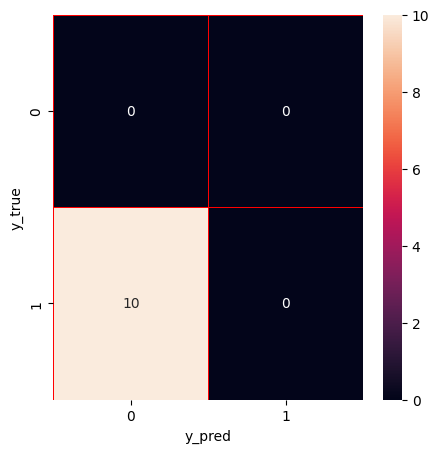

In [10]:
# Example usage with the tfd dataframe
name1 = "HT model on tfd"
predictions = predict_and_plot(model, df, name1)